In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
df = pd.read_excel("./hindi_spam_3K.xlsx")
df

,type,text
0,ham,हर सामुदायिक स्तर पर ईमानदारी और कर्मठता से प्...
1,ham,प्लेयर्स को लंबे समय तक बर्फ पर चलने से खुद को...
2,ham,सज्जन! हम आपसे संपर्क करने का प्रयास कर रहे है...
3,spam,राजश्री कावेरी लॉटरी घोषित होने के आधे घंटे बा...
4,ham,धार्मिक पर्वों और उत्सवों की अभिवृद्धि के साथ-...
...,...,...
2995,ham,हाय इट्स केट आपकी शाम कैसी है? मुझे आशा है कि ...
2996,spam,"एक अधिकारी के अनुसार, यदि किसी लॉटरी एजेंट ने ..."
2997,spam,शॉपिंग अभियान बनाते समय आप निर्णय लेते हैं कि ...
2998,ham,इसके साथ ही छुप कर अटैक करने का भी एक अलग रोमा...


In [5]:
# checking for cuda
print ('Is CUDA available: ', torch.cuda.is_available())
print ('CUDA version: ', torch.version.cuda )
print ('Current Device ID: ', torch.cuda.current_device())
print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

Is CUDA available:  True
CUDA version:  11.8
Current Device ID:  0
Name of the CUDA device:  Tesla T4


In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [27]:
x , y = df['text'] , df['type']

In [28]:
lbl = LabelEncoder()
y = lbl.fit_transform(y)

In [29]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [30]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [31]:
y_train , y_test = np.array(y_train), np.array(y_test)

In [32]:
def preprocess_text(text):
    # You may need to implement more advanced preprocessing steps
    return text.split()

# Convert text data to numerical data
vocab = set()
for text in x:
    tokens = preprocess_text(text)
    vocab.update(tokens)

In [33]:
vocab_size = len(vocab)
embedding_dim = 100  # you may need to change this according to your task 100 is standard value
max_length = max(len(seq) for seq in x)
trunc_type= 'post'

In [34]:
# Tokenize and pad sequences
def tokenize_hindi(text):
    tokens = word_tokenize(text,language='hindi',preserve_line=True)
    return tokens

trn_seq = [tokenize_hindi(item) for item in X_train]
tst_seq = [tokenize_hindi(item) for item in X_test]

In [35]:
word_to_idx = {}
for seq in trn_seq + tst_seq:
    for word in seq:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)

In [36]:
trn_pad = [torch.tensor([word_to_idx[word] for word in seq]) for seq in trn_seq]
trn_pad = nn.utils.rnn.pad_sequence(trn_pad, batch_first=True, padding_value=0)
tst_pad = [torch.tensor([word_to_idx[word] for word in seq]) for seq in tst_seq]
tst_pad = nn.utils.rnn.pad_sequence(tst_pad, batch_first=True, padding_value=0)

In [37]:
# Define the RNN Model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(32, 10),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_output, _ = self.rnn(embedded)
        rnn_output = rnn_output[:, -1, :]  # Get the last output of RNN sequence
        output = self.fc(rnn_output)
        return output

In [38]:
# Instantiate the model
hidden_dim = 256
alpha = 0.001
model_rnn = RNNModel(vocab_size, embedding_dim, hidden_dim)

# Define loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model_rnn.parameters(),lr=alpha)

In [39]:
# Create DataLoader
train_dataset = TensorDataset(trn_pad, torch.tensor(y_train, dtype=torch.float))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(tst_pad, torch.tensor(y_test, dtype=torch.float))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [40]:
# for df

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

# Training loop
for epoch in range(5):
    model_rnn.train()
    train_loss = 0.0
    train_acc = 0.0
    for batch_inputs, batch_labels in train_loader:
        optimizer.zero_grad()
        batch_outputs = model_rnn(batch_inputs.long())

        predicted = torch.round(batch_outputs)

        batch_loss = loss_fn(batch_outputs.squeeze(), batch_labels)
        batch_acc = accuracy_score(batch_labels.cpu().numpy(),
                                   predicted.detach().cpu().numpy())
        batch_loss.backward()
        optimizer.step()

        train_loss += batch_loss.item() * batch_inputs.size(0)
        train_acc += batch_acc * batch_inputs.size(0)

    train_loss /= len(train_dataset)
    train_acc /= len(train_dataset)

    loss.append(train_loss)
    acc.append(train_acc)

    # Evaluation
    model_rnn.eval()
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        correct = 0
        total = 0
        for batch_inputs, batch_labels in test_loader:
            batch_outputs = model_rnn(batch_inputs.long())
            predicted = torch.round(batch_outputs)

            batch_loss = loss_fn(batch_outputs.squeeze(), batch_labels)
            batch_acc = accuracy_score(batch_labels.cpu().numpy(),
                                       predicted.detach().cpu().numpy())

            test_loss += batch_loss.item() * batch_inputs.size(0)
            test_acc += batch_acc* batch_inputs.size(0)

            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

        test_loss /= len(test_dataset)
        test_acc /= len(test_dataset)

        tloss.append(test_loss)
        tacc.append(test_acc)


        accuracy = correct / total
        print(f"AUTO: Epoch {epoch+1}, Test Accuracy: {accuracy:.4f}")

    n_epoch.append(epoch)

    print(f'MINE: At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')

AUTO: Epoch 1, Test Accuracy: 21.8933
MINE: At epoch 0 | Loss - train:0.6258, test:0.6179 | Acc - train:0.6850, test:0.6917
AUTO: Epoch 2, Test Accuracy: 21.8933
MINE: At epoch 1 | Loss - train:0.6218, test:0.6193 | Acc - train:0.6929, test:0.6917
AUTO: Epoch 3, Test Accuracy: 21.8933
MINE: At epoch 2 | Loss - train:0.6282, test:0.6254 | Acc - train:0.6967, test:0.6917
AUTO: Epoch 4, Test Accuracy: 21.8933
MINE: At epoch 3 | Loss - train:0.6231, test:0.6242 | Acc - train:0.7017, test:0.6917
AUTO: Epoch 5, Test Accuracy: 21.8933
MINE: At epoch 4 | Loss - train:0.6238, test:0.6183 | Acc - train:0.7017, test:0.6917


In [41]:
loss_df = pd.DataFrame({'epoch' : n_epoch, 'loss' : loss, 'test_loss': tloss, 'acc' : acc, 'test_acc': tacc})
loss_df

,epoch,loss,test_loss,acc,test_acc
0,0,0.625847,0.617892,0.685000,0.691667
1,1,0.621778,0.619341,0.692917,0.691667
2,2,0.628184,0.625430,0.696667,0.691667
3,3,0.623104,0.624230,0.701667,0.691667
4,4,0.623844,0.618299,0.701667,0.691667


In [42]:
import matplotlib.pyplot as plt

###-----------------------------------
### parameters for Matplotlib
###-----------------------------------

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def plot_hist(hist_df):

    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # Where was min loss
    best = hist_df[hist_df['test_loss'] == hist_df['test_loss'].min()]

    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = 'epoch', y = ['loss', 'test_loss'], ax = ax)

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(loss_df.iloc[-1]['loss'],
                           loss_df.iloc[-1]['test_loss']) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best["test_loss"].to_numpy()[0]:6.4f}', # text to print
                xy=(best['epoch'].to_numpy(), best["test_loss"].to_numpy()[0]), # Arrow start
                xytext=(best['epoch'].to_numpy()+0.01, best["test_loss"].to_numpy()[0]+0.01), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best['epoch'].to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = 'epoch', y = ['acc', 'test_acc'], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(loss_df.iloc[-1]['acc'],
                           loss_df.iloc[-1]['test_acc']) #text to plot

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best["test_acc"].to_numpy()[0]:6.4f}', # text to print
                xy=(best['epoch'].to_numpy(), best["test_acc"].to_numpy()[0]), # Arrow start
                xytext=(best['epoch'].to_numpy()-2, best["test_acc"].to_numpy()[0]), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow


    # Draw a vertical line at best value
    ax.axvline(x = best['epoch'].to_numpy(),
               color = 'green',
               linestyle='-.', lw = 3)

    # Labels
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')

    plt.tight_layout()

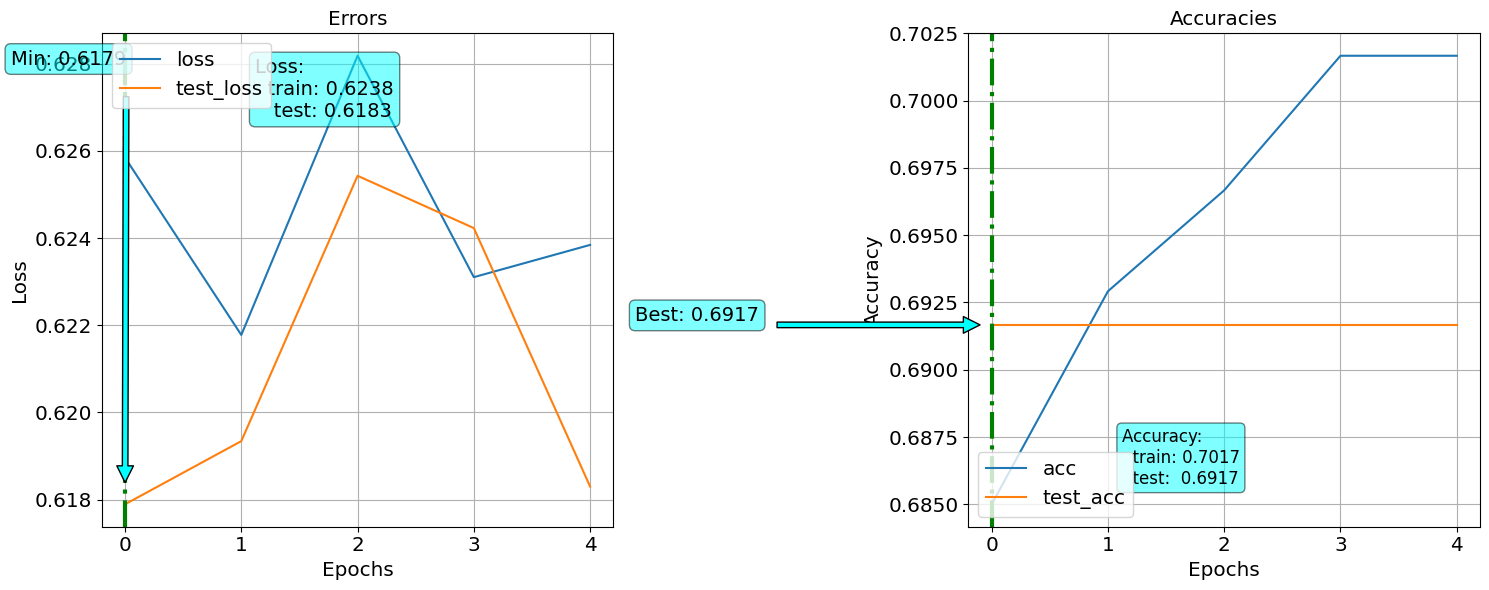

In [43]:
plot_hist(loss_df)

In [ ]:
model_rnn.save("model_rnn_pytorch.h5")